# Exemple de bouton

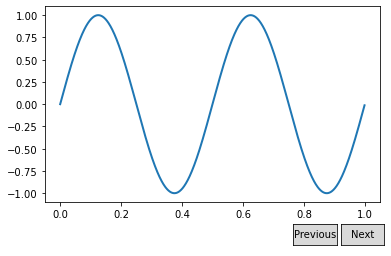

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

freqs = np.arange(2, 20, 3)

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
t = np.arange(0.0, 1.0, 0.001)
s = np.sin(2*np.pi*freqs[0]*t)
l, = plt.plot(t, s, lw=2)


class Index:
    ind = 0

    def next(self, event):
        self.ind += 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

    def prev(self, event):
        self.ind -= 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

# Exemple de Slider

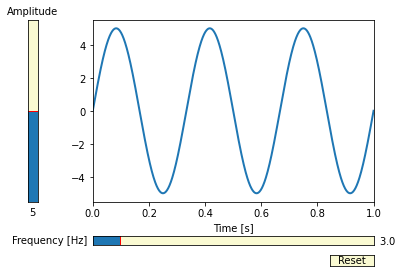

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

# Ajustement affine

<IPython.core.display.Javascript object>


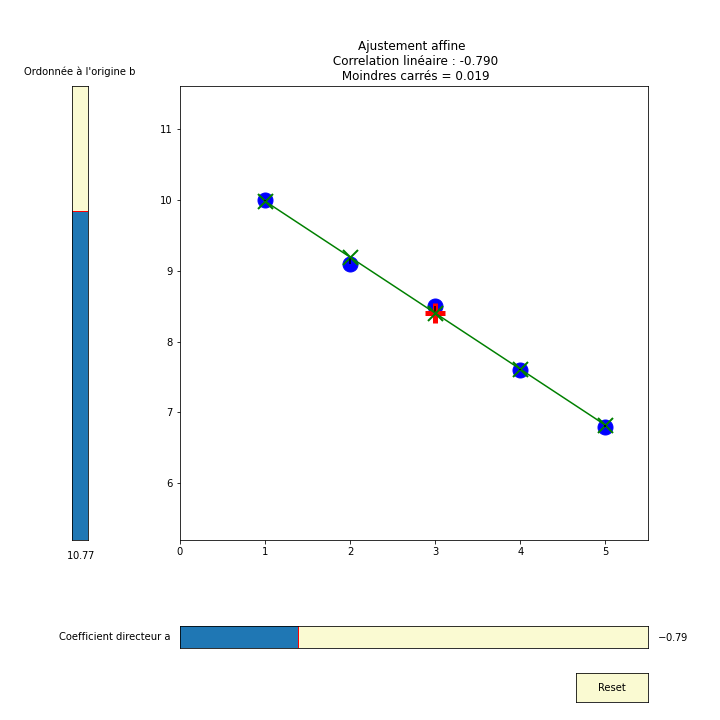

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from typing import List
import csv
import sys
import os.path
from pathlib import Path, PurePath

from numpy.lib.function_base import cov

def moyenne(x:List[int]):
    return sum(x) / len(x)

def covariance(x:List[float], y:List[float])->float:
    assert len(x) == len(y)
    n = len(x)
    xm = moyenne(x)
    ym = moyenne(y)
    return sum((xi - xm) * (yi - ym) for (xi, yi) in zip(x, y)) / n

def variance(x:List[int])->float:
    return covariance(x, x)

def correlation_lineaire(x:List[float], y:List[float])->float:
    covxy = covariance(x,y)
    varx = covariance(x, x)
    return covxy / varx

def moindres_carre(y1:List[int], y2:List[int])->float:
    assert len(y1) == len(y2)
    return sum((y1[i] - y2[i]) ** 2 for i in range(len(y1)))

def dessiner_nuage(x:List[float], y:List[float], point_moyen:bool=True, a:float=0,b:float=0, path:str='exemple.csv')->None:
    
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 10))   

    xmin, xmax = min(x), max(x)
    ymin, ymax  = min(y), max(y)
    ax.set_xlim([0, xmax * 1.1])
    ax.set_ylim([ymin - (ymax - ymin) / 2, ymax + (ymax - ymin)/2])
    axcolor = 'lightgoldenrodyellow'
    ax.margins(x=0)
    

    # adjust the main plot to make room for the sliders
    plt.subplots_adjust(left=0.25, bottom=0.25)
    
    #conversion en ndarray
    x = np.array(x)
    y = np.array(y)
    
    #indicateurs de corrélation
    correl_xy = correlation_lineaire(x, y)

   
    #dessin du nuage
    nuage, = ax.plot(x, y, ls='', marker='o', color = 'b',  markersize=15)
    
    #point moyen
    xg = moyenne(x)
    yg = moyenne(y)
    point_moyen, =  ax.plot([xg], [yg], marker='+', color = 'r', markeredgewidth=5, markersize=20)


    #fonction affine d'ajustement
    def f(x, a, b):
        return a * x + b

    a_init = covariance(x, y) / variance(x)
    b_init = yg - a_init * xg
    droite, = ax.plot(x, f(x, a_init, b_init) , ls='-', marker='x', color = 'g', markeredgewidth=2, markersize=15)

    
    #moindres carrés
    segments = [ax.plot([x[k], x[k]], [y[k], f(x[k], a_init, b_init)], '-', ls='dashed', color='black')[0] for k in range(len(x))]
    
    
    # Slider_horizontal to control the coef     a
    
    pente_extremite = (y[-1] - y[0])/(x[-1] - x[0])
    ax_a = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    a_slider = Slider(
        ax=ax_a,
        label="Coefficient directeur a",
        valmin= - abs(pente_extremite) * 2,
        valmax= abs(pente_extremite) * 2,
        valinit=a_init,
    )

    # Make a vertically oriented slider to control the coef b
    ax_b = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
    b_slider = Slider(
        ax=ax_b,
        label="Ordonnée à l'origine b",
        valmin=-2* ymin,
        valmax=2 * ymax,
        valinit=b_init,
        orientation="vertical"
    )

    #Titre
    y_ajust = f(x, a_slider.val, b_slider.val)
    ax.set_title(f'Ajustement affine \n Correlation linéaire : {correlation_lineaire(x, y):.3f}\n Moindres carrés = {moindres_carre(y,y_ajust):.3f}')

    # The function to be called anytime a slider's value changes
    def update(val):
        y_ajust = f(x, a_slider.val, b_slider.val)
        droite.set_ydata(y_ajust)
        for k, seg in enumerate(segments):
            seg.set_ydata([y[k], f(x[k], a_slider.val, b_slider.val)])
        ax.set_title(f'Ajustement affine \n Correlation linéaire : {correlation_lineaire(x, y):.3f}\n Moindres carrés = {moindres_carre(y,y_ajust):.3f}')
        fig.canvas.draw_idle()


    # register the update function with each slider
    a_slider.on_changed(update)
    b_slider.on_changed(update)

    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


    def reset(event):
        a_slider.reset()
        b_slider.reset()
        
    button.on_clicked(reset)
    
    plt.show()
    fig.savefig(filename.split('.')[-2] + '.png')
    
filepath = "exemple.csv"  
if Path(filepath).exists():
    filename = PurePath(filepath).name
    f = open(filepath, mode = 'r', encoding = 'utf8', newline='')
    reader = csv.reader(f, delimiter = ',')
    table = np.array([[float(champ) for champ in ligne] for ligne in reader])
    f.close()
    x = table[:,0]
    y = table[:,1]
    dessiner_nuage(x, y)
